In [1]:
import netgen.occ as occ

# x = 1.25
# y = 0.75

x = 100
y = 100

points = [[ 0.25, 0,    0], [ 0.25, 0.50, 0], [ 0.50, 0.50, 0], [ 0.75, 0,    0],
          [ 0.75, 0.75, 0], [ 0.50, 0,    0], [-0.75, 0.75, 0], [-0.75, 0    ,0],
          [-0.25, 0    ,0], [-0.25, 0.5  ,0], [-0.50, 0.5  ,0], [-0.50, 0    ,0],
          [ 0.75,-0.025,0], [-0.75,-0.025,0], [-0.75,-0.275,0], [ 0.75,-0.275,0],
          [-x, x ,0], [ x, x ,0], [ x,-y ,0], [-x,-y ,0]]

edges = [[9,10],[10,11],[11,8],[8,9], [2,1],[1,0],[0,5],[5,2], [17,16],[16,19],[19,18],[18,17], [3,7],[7,6],[6,4],[4,3], [15,14],[14,13],[13,12],[12,15], [12,3],[7,13]]
faces = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[18,20,13,21]]

e = {}
for i,j in enumerate(edges): e[i] = occ.Segment(tuple(points[j[0]]),tuple(points[j[1]]))

f = {}
for i,j in enumerate(faces): f[i] = occ.Face(occ.Wire([e[j[0]],e[j[1]],e[j[2]],e[j[3]]]))

geo = occ.Glue(list(f.values()))

geo.faces[0].name = 'coil_plus'; geo.faces[0].col = (1,0.5,0)
geo.faces[1].name = 'coil_minus'; geo.faces[1].col = (1,0.5,0)
geo.faces[2].name = 'air';   geo.faces[2].col = (0,0.5,1)
geo.faces[3].name = 'iron';  geo.faces[3].col = (0,0.5,0)
geo.faces[4].name = 'air';   geo.faces[4].col = (0,0.5,1)
geo.faces[5].name = 'iron';  geo.faces[5].col = (0,0.5,0)

geo.edges[8].name = 'outer'
geo.edges[9].name = 'outer'
geo.edges[10].name = 'outer'
geo.edges[11].name = 'outer'

area_coil = geo.faces[0].mass
inch_to_meter = 1/39.3701

scale = 1*100
solver = "sparsecholesky"
# solver = "pardiso"
# scale = 0.2*0.9

h = 0.1*scale
# hh = 0.01*scale
hh = 0.1*scale

for i in range(50):
    geo.vertices[i].maxh = hh

In [2]:
import ngsolve as ng
from ngsolve.webgui import Draw
import time
import numpy as np

geoOCC = occ.OCCGeometry(geo, dim = 2)
with ng.TaskManager():
    geoOCCmesh = geoOCC.GenerateMesh(maxh = h)
    mesh = ng.Mesh(geoOCCmesh)
    
print(mesh.ne)

order = 2
J = 66/area_coil
# s = 58*1e6

muAir = 1
muCoil = 1
muIron = 2500
pi = 3.14159265359
mu0 = 4e-7*pi


Draw(mesh)

1866


Current densiry : we have $66$ Amp-turns on a surface of 0.125 $m^2$, so $J = 66A/0.125 m^2 = 528 A/m^2$

In [3]:
def ComputePrimal():
    tm = time.monotonic()
    H1 = ng.H1(mesh = mesh, order = order, dirichlet='outer')
    u,v = H1.TnT()
    
    # sigma = mesh.MaterialCF({"coil_plus": s, "coil_minus": s}, default=1)
    mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
    
    K = ng.BilinearForm(H1)
    K += 1/mu*ng.grad(u)*ng.grad(v)*ng.dx
    
    with ng.TaskManager(): K.Assemble()
    
    coil_plus  =  1 * J * v * ng.dx(definedon = mesh.Materials("coil_plus"))
    coil_minus = -1 * J * v * ng.dx(definedon = mesh.Materials("coil_minus"))
    f = ng.LinearForm(coil_plus + coil_minus).Assemble(); # fnp = f.vec.FV().NumPy()
    
    A = ng.GridFunction(H1)
    
    with ng.TaskManager(): A.vec.data = K.mat.Inverse(H1.FreeDofs(), inverse=solver) * f.vec
    
    B = ng.grad(A)
    H = 1/mu*B

    print("Primal formulation with %d DOFs took %.4f seconds" % (np.where(H1.FreeDofs())[0].size, time.monotonic()-tm))
    return B,H

B, H = ComputePrimal()
# Draw(A,mesh)

Primal formulation with 3653 DOFs took 0.0139 seconds


In [4]:
# Duales Problem :

def ComputeDual():
    tm = time.monotonic()
    HCurl = ng.HCurl(mesh = mesh, order = order, nograds=True)
    u,v = HCurl.TnT()
    mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
    
    K = ng.BilinearForm(HCurl)
    K += ng.curl(u)*ng.curl(v)*ng.dx + u*v*1e-7*ng.dx
    with ng.TaskManager(): K.Assemble()
    
    coil_plus  =  1 * J * ng.curl(v) * ng.dx(definedon = mesh.Materials("coil_plus"))
    coil_minus = -1 * J * ng.curl(v) * ng.dx(definedon = mesh.Materials("coil_minus"))
    f = ng.LinearForm(coil_plus + coil_minus).Assemble(); # fnp = f.vec.FV().NumPy()
    
    
    import scipy.sparse as sp
    import matplotlib.pyplot as plt
    rows,cols,vals = K.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    # plt.spy(A,markersize=1)
    
    Hj = ng.GridFunction(HCurl)
    with ng.TaskManager(): Hj.vec.data = K.mat.Inverse(HCurl.FreeDofs(), inverse=solver) * f.vec
    # Draw(Hj,mesh)
    
    H1 = ng.H1(mesh = mesh, order = order)
    u,v = H1.TnT()
    
    K = ng.BilinearForm(H1)
    K += mu*ng.grad(u)*ng.grad(v)*ng.dx
    with ng.TaskManager(): K.Assemble()
    
    f = ng.LinearForm(-mu*(Hj*ng.grad(v))*ng.dx).Assemble()
    
    psi = ng.GridFunction(H1)
    with ng.TaskManager(): psi.vec.data = K.mat.Inverse(H1.FreeDofs(), inverse=solver) * f.vec
    
    BD = mu*(ng.grad(psi)+Hj)
    # Draw(BD,mesh)
    print("Dual formulation with %d DOFs (Hj) and %d DOFs (pot) took %.4f seconds" % (np.where(HCurl.FreeDofs())[0].size, np.where(H1.FreeDofs())[0].size, time.monotonic()-tm))
    return BD

BD = ComputeDual()
# Draw(B,mesh)
# Draw(BD,mesh)

Dual formulation with 6571 DOFs (Hj) and 3813 DOFs (pot) took 1.2168 seconds


In [5]:
# Draw(mu, mesh)
# Draw(A, mesh)
# Draw(B, mesh)
# Draw(H, mesh)
# Draw(B*H, mesh)

In [6]:
mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
Energy = 1/2*ng.Integrate(1/mu*B*B, mesh)
Inductance = 1*inch_to_meter*2*Energy*1000
print("  Energy approach : L = %.6f" % Inductance, "mH")

CoEnergy = 1/2*ng.Integrate(1/mu*BD*BD, mesh)
Inductance = 1*inch_to_meter*2*CoEnergy*1000
print("Coenergy approach : L = %.6f" % Inductance, "mH")

  Energy approach : L = 1.693465 mH
Coenergy approach : L = 1.873032 mH


In [7]:
import matplotlib.pyplot as plt
import numpy as np

iter = 10

EnergyInductance = np.zeros(iter)
CoenergyInductance = np.zeros(iter)
dofs = np.zeros(iter)

for i in range(iter):
    B, H = ComputePrimal()
    BD = ComputeDual()
    
    dofs[i] = mesh.ne
    #############################################################################################################
    mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
    Energy = 1/2*ng.Integrate(1/mu*B*B, mesh)
    EnergyInductance[i] = 1*inch_to_meter*2*Energy*1000
    print("  Energy approach : L = %.6f" % EnergyInductance[i], "mH")
    
    CoEnergy = 1/2*ng.Integrate(1/mu*BD*BD, mesh)
    CoenergyInductance[i] = 1*inch_to_meter*2*CoEnergy*1000
    print("Coenergy approach : L = %.6f" % CoenergyInductance[i], "mH")
    #############################################################################################################

    elerr = ng.Integrate(1/mu*(B-BD)*(B-BD), mesh, ng.VOL, element_wise=True)
    maxerr = max(elerr)
    # plt.plot(np.sort(elerr))

    elerrNP = elerr.NumPy()
    a = np.argsort(elerrNP)
    sorted_elerrNP = elerrNP[a]
    
    procentage = (1-0.7071)
    total_error = np.sum(elerrNP)
    cum_sum_error = np.cumsum(sorted_elerrNP)
    indices = np.where(cum_sum_error>procentage*total_error)[0]
    mapped_indices = a[indices]
    
    if i!=iter-1:
        print("Max. error: ", maxerr, "\n")
        for el in mesh.Elements():
            # mesh.SetRefinementFlag(el, elerr[el.nr] > 0.25*maxerr)
            mesh.SetRefinementFlag(el, el.nr in mapped_indices)
        mesh.Refine()
        print(i,iter-2,". New mesh elements : #", mesh.nv)

# B, H = ComputePrimal()
# BD = ComputeDual()

Primal formulation with 3653 DOFs took 0.0121 seconds
Dual formulation with 6571 DOFs (Hj) and 3813 DOFs (pot) took 0.0253 seconds
  Energy approach : L = 1.693465 mH
Coenergy approach : L = 1.873032 mH
Max. error:  0.016540369620538148 

0 8 . New mesh elements : # 1033
Primal formulation with 3889 DOFs took 0.0098 seconds
Dual formulation with 6984 DOFs (Hj) and 4049 DOFs (pot) took 0.0192 seconds
  Energy approach : L = 1.763496 mH
Coenergy approach : L = 1.819799 mH
Max. error:  0.004276123499303347 

1 8 . New mesh elements : # 1202
Primal formulation with 4565 DOFs took 0.0128 seconds
Dual formulation with 8167 DOFs (Hj) and 4725 DOFs (pot) took 0.0241 seconds
  Energy approach : L = 1.777437 mH
Coenergy approach : L = 1.805862 mH
Max. error:  0.0012148314418422047 

2 8 . New mesh elements : # 1612
Primal formulation with 6205 DOFs took 0.0146 seconds
Dual formulation with 11037 DOFs (Hj) and 6365 DOFs (pot) took 0.0296 seconds
  Energy approach : L = 1.784630 mH
Coenergy approa

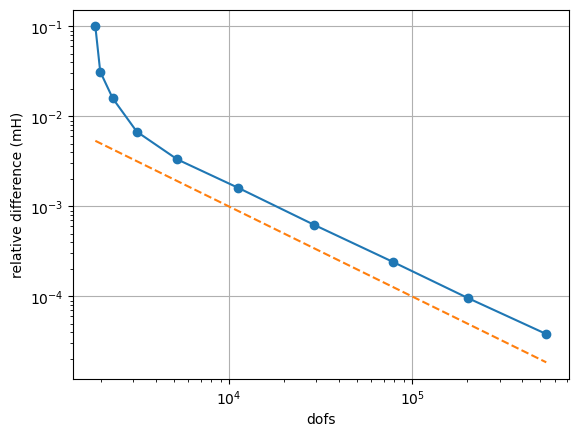

In [8]:
# Lenergy = np.array([1.630851,  1.712054, 1.741341, 1.755524, 1.762939, 1.766497, 1.768369, 1.769229])
# Lcoenergy = np.array( [1.902567, 1.827913 , 1.796361, 1.782765, 1.776124, 1.772970 , 1.771329, 1.770598])
# dofs = np.array([792,  1256,  2623, 6589,  18881, 51947, 143739, 260906])

plt.loglog(dofs,(CoenergyInductance-EnergyInductance)/EnergyInductance[-1],'o-')
plt.loglog(dofs,10/dofs,'--')

plt.xlabel("dofs")
plt.ylabel("relative difference (mH)")
plt.grid()

In [9]:
elerrNP = elerr.NumPy()
a = np.argsort(elerrNP)
sorted_elerrNP = elerrNP[a]

procentage = 0.8
total_error = np.sum(elerrNP)
cum_sum_error = np.cumsum(sorted_elerrNP)
indices = np.where(cum_sum_error>procentage*total_error)[0]

mapped_indices = a[indices]



# plt.plot(elerrNP)

# plt.plot(elerrNP[a])
# print(cum_sum_error, total_error, indices, mapped_indices)


In [10]:
Draw(B, mesh)

In [11]:
# H1 = ng.H1(mesh = mesh, order = order, dirichlet='outer')
# print(np.where(H1.FreeDofs())[0].size)
# H1.ndof

In [19]:
print(mesh.nv)
print(mesh.nface)
print(mesh.nedge)
print(mesh.ne)

order = 1
HCurl = ng.HCurl(mesh = mesh, order = order, nograds=True)
HCurl.ndof

269858
735572
1078375
539634


1078375